In this Notebook, we implemented the SMOTE method to rebalance our dataset and increase the importance of minorities.

# Extraction

In [ ]:
!pip install -U -q PyDrive
!pip install -U scikit-learn
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import CategoricalNB
import seaborn as sn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

link="https://drive.google.com/open?id=1ekH_MmN_ofsmz6bR3xHrRnmDfXSDCWQK"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')
hSSW_wdeltabike= pd.read_csv('myfile.csv')
print('hSSW_wdeltabike imported')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


hSSW_wdeltabike imported


In [ ]:
hSSW_wdeltabike

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,634687,70,6,13,False,True,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,19,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634688,634688,71,5,14,False,True,Powell at Post (Union Square),37.788446,-122.408499,19,San Francisco,8/23/2013,-2.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634689,634689,72,14,9,False,True,Civic Center BART (7th at Market),37.781039,-122.411748,23,San Francisco,8/23/2013,0.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1
634690,634690,73,10,4,False,True,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,8/21/2013,-3.0,9/28/2014 14:00,100.0,1024,286.7370,sky is clear,159,1


In [ ]:
hSSW_wdeltabike['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

# Coherence Check and Cleaning

<BarContainer object of 14 artists>

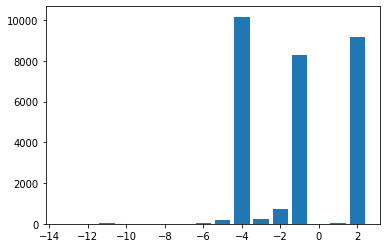

In [ ]:
hSSW_wdeltabike['check']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']-hSSW_wdeltabike['dock_count']
unique,count=np.unique(hSSW_wdeltabike['check'],return_counts=True)
plt.bar(np.delete(unique,-3),np.delete(count,-3)) #delete count of value 0

<BarContainer object of 69 artists>

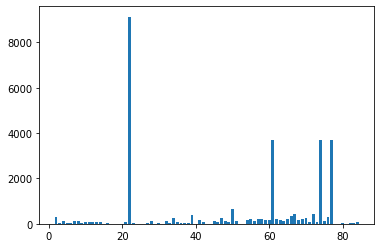

In [ ]:
unique_id,count_id=np.unique(hSSW_wdeltabike[hSSW_wdeltabike['check']!=0]['station_id'],return_counts=True)
plt.bar(unique_id,count_id)

In [ ]:
unique_id,count_id

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
        24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
        45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83,
        84], dtype=int64),
 array([ 298,   56,  124,   52,   38,  105,  110,   33,   78,   78,   83,
          98,   84,   50,   60, 9130,   22,    2,    4,   23,  122,    2,
          22,    5,  112,   45,  257,   70,   15,   30,   26,  382,  162,
         100,  133,   63,  261,  104,   79,  667,  110,  147,  227,  107,
         200,  212,  174,  161, 3675,  198,  170,  133,  207,  341,  434,
         172,  223,  246,   82,  434,   66, 3715,  118,  317, 3714,   19,
          56,   32,   66]))

In [ ]:
count_id[np.argsort(count_id)[-4:]],unique_id[np.argsort(count_id)[-4:]]

(array([3675, 3714, 3715, 9130]), array([61, 77, 74, 22], dtype=int64))

In [ ]:
np.unique(hSSW_wdeltabike[hSSW_wdeltabike['station_id']==22]['check'],return_counts=True)

(array([-1,  0,  1,  2], dtype=int64), array([   3,  250,   39, 9088]))

We can certainly deduce an error in the dock count. In addition, the number of bikes and docks available is varaible, contrary to the dock_count, which is fixed. If some docks are under repair, we will see them in the availability variable, but not in the dock_count.

In [ ]:
np.unique(hSSW_wdeltabike['dock_count'],return_counts=True)

(array([11, 15, 19, 23, 25, 27], dtype=int64),
 array([ 34598, 300137, 168663,  84397,   9380,  37517]))

In [ ]:
hSSW_wdeltabike['dock_total']=hSSW_wdeltabike['bikes_available']+hSSW_wdeltabike['docks_available']

# Categorical Label Implementation

In [ ]:
hSSW_wdeltabike['Category']=1

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['bikes_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=0
hSSW_wdeltabike.loc[(hSSW_wdeltabike['docks_available']/hSSW_wdeltabike['dock_total'])<0.1,'Category']=2

# Features Selection and Modification

### City

In [ ]:
City=pd.get_dummies(hSSW_wdeltabike['city'])
City.head()

,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Weather

In [ ]:
hSSW_wdeltabike['Weather_Description'].unique()

array(['broken clouds', 'mist', 'few clouds', 'sky is clear',
       'thunderstorm', 'scattered clouds', 'overcast clouds',
       'moderate rain', 'light rain', 'proximity thunderstorm', 'fog',
       'haze', 'light intensity drizzle', 'heavy intensity drizzle',
       'drizzle', 'thunderstorm with rain', 'proximity shower rain',
       'thunderstorm with light rain', 'heavy intensity rain',
       'very heavy rain', 'thunderstorm with heavy rain',
       'proximity thunderstorm with rain', 'light intensity shower rain'],
      dtype=object)

Goal: Simplify the Weather Description to a more General weather:
- Sunny: Sky is clear
- Cloudy: Broken clouds, Few clouds, Scattered clouds, Overcast clouds
- Foggy: Mist, Fog, Haze, 
- Light Rain: light rain, light intensity drizzle, thunderstorm with light rain,light intensity shower rain
- Moderate Rain: moderate rain, drizzle, thunderstorm with rain
- Heavy Rain: heavy intensity rain, heavy intensity drizzle, thunderstorm with heavy rain, very heavy rain
- Proximity to Rain: thunderstorm, proximity thunderstorm, proximity shower rain, proximity thunderstorm with rain

In [ ]:
hSSW_wdeltabike['Weather_Simplified']=hSSW_wdeltabike['Weather_Description']

In [ ]:
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='sky is clear','Weather_Simplified']='Sunny'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='broken clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='few clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='scattered clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='overcast clouds','Weather_Simplified']='Cloudy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='mist','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='fog','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='haze','Weather_Simplified']='Foggy'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity drizzle','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with light rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='light intensity shower rain','Weather_Simplified']='Light Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='moderate rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='drizzle','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with rain','Weather_Simplified']='Moderate Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='heavy intensity drizzle','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm with heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='very heavy rain','Weather_Simplified']='Heavy Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity shower rain','Weather_Simplified']='Proximity to Rain'
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Description']=='proximity thunderstorm with rain','Weather_Simplified']='Proximity to Rain'

In [ ]:
hSSW_wdeltabike['Rain']=1
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Sunny','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Cloudy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Foggy','Rain']=0
hSSW_wdeltabike.loc[hSSW_wdeltabike['Weather_Simplified']=='Proximity to Rain','Rain']=0

Weather Description from 23 to 7 categories, and an additional dummy Rain column.

In [ ]:
Weather_Simplified=pd.get_dummies(hSSW_wdeltabike['Weather_Simplified'])
Weather_Simplified.head()

,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


### Wind Direction

In [ ]:
hSSW_wdeltabike['Wind_Orientation']='North'

In [ ]:
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>45) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=135),'Wind_Orientation']='East'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>135) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=225),'Wind_Orientation']='South'
hSSW_wdeltabike.loc[(hSSW_wdeltabike['Wind_Direction'].astype(int)>225) & (hSSW_wdeltabike['Wind_Direction'].astype(int)<=315),'Wind_Orientation']='West'

In [ ]:
Wind_Orientation=pd.get_dummies(hSSW_wdeltabike['Wind_Orientation'])
Wind_Orientation.head()

,East,North,South,West
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


### Time

In [ ]:
hSSW_wdeltabike['Hour']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.hour
hSSW_wdeltabike['Month']=hSSW_wdeltabike['datetime'].astype('datetime64').dt.month

In [ ]:
hSSW_wdeltabike.head()

,Unnamed: 0,station_id,bikes_available,docks_available,Holiday,Weekend,name,lat,long,dock_count,city,installation_date,delta_bike,datetime,Humidity,Pressure,Temperature,Weather_Description,Wind_Direction,Wind_Speed,check,dock_total,Category,Weather_Simplified,Rain,Wind_Orientation,Hour,Month
0,0,2,2,25,False,False,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,27,0,Cloudy,0,South,13,8
1,1,3,9,6,False,False,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8
2,2,4,0,11,False,False,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,11,0,Cloudy,0,South,13,8
3,3,5,9,10,False,False,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,19,1,Cloudy,0,South,13,8
4,4,6,4,11,False,False,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,NaN,8/29/2013 13:00,94.0,1021,287.2795,broken clouds,201,0,0,15,1,Cloudy,0,South,13,8


### Merge

In [ ]:
ML_data=hSSW_wdeltabike[['Category','station_id','bikes_available','docks_available','Holiday','Weekend','Humidity','Pressure','Temperature',\
                         'Wind_Direction','Wind_Speed','Rain','Hour','Month']]

In [ ]:
ML_data=pd.merge(ML_data,City,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Weather_Simplified,left_index=True,right_index=True)
ML_data=pd.merge(ML_data,Wind_Orientation,left_index=True,right_index=True)

In [ ]:
ML_data=ML_data.astype({'Holiday': int, 'Weekend': int})

In [ ]:
ML_data

,Category,station_id,bikes_available,docks_available,Holiday,Weekend,Humidity,Pressure,Temperature,Wind_Direction,Wind_Speed,Rain,Hour,Month,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,Cloudy,Foggy,Heavy Rain,Light Rain,Moderate Rain,Proximity to Rain,Sunny,East,North,South,West
0,0,2,2,25,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,1,3,9,6,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,4,0,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3,1,5,9,10,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
4,1,6,4,11,0,0,94.0,1021,287.2795,201,0,0,13,8,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634687,1,70,6,13,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634688,1,71,5,14,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634689,1,72,14,9,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
634690,1,73,10,4,0,1,100.0,1024,286.7370,159,1,0,14,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


# Machine Learning Models

### SMOTE

First, we implement a beginning model with all features

In [ ]:
data1=ML_data.copy()

In [ ]:
data1.drop(columns=['bikes_available','docks_available','Wind_Direction'],inplace=True)

In [ ]:
X1_rest,X1_test,Y1_rest,Y1_test=train_test_split(data1.drop(columns=['Category']),data1['Category'],train_size=0.8,shuffle=True)
X1_train,X1_validation,Y1_train,Y1_validation=train_test_split(X1_rest,Y1_rest,train_size=0.8,shuffle=True)

We saw in the ML_Algo_KNN_RF_LDA Notebook that the best Nearest Neighbor Classifier parameter is 3, so we implement it again in the SMOTE Method. We are using a 'not majority' sampling startegy, we equalize all sampling at the number of the majority group.

In [ ]:
model0=SMOTE(sampling_strategy='not majority',k_neighbors=3)

In [ ]:
Xresamp0_train,Yresamp0_train=model0.fit_sample(X1_train,Y1_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
modelK0=KNeighborsClassifier(3)
modelK0.fit(Xresamp0_train,Yresamp0_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y1_validation_pred=modelK0.predict(X1_validation)
np.average(Y1_validation_pred==Y1_validation)

0.8942501797126567

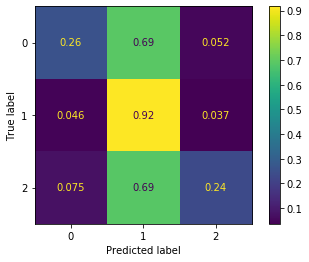

In [ ]:
CM0_SMOTE=plot_confusion_matrix(modelK0,X1_validation,Y1_validation,normalize='true')

We fit our new data to a KNN model, and get better results on the minorities that the one we get without resampling data.

We also tested it on the same data set, but by changing the weight of each class.

In [ ]:
model1=SMOTE(sampling_strategy={0:240000,1:400000,2:270000},k_neighbors=3)

In [ ]:
Xresamp1_train,Yresamp1_train=model1.fit_sample(X1_train,Y1_train)

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (400000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 392284)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=Futu

In [ ]:
modelK1=KNeighborsClassifier(3)
modelK1.fit(Xresamp1_train,Yresamp1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y1_validation_pred=modelK1.predict(X1_validation)
np.average(Y1_validation_pred==Y1_validation)

0.8965741351636124

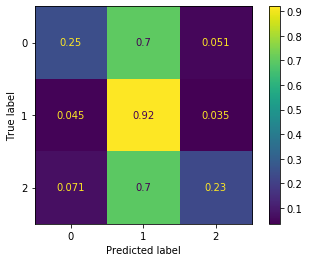

In [ ]:
CM1_SMOTE=plot_confusion_matrix(modelK1,X1_validation,Y1_validation,normalize='true')

We get worse result. Thus, we keep our equal strategy.

We also wanted to test Under Sampling, by selecting only a few number of our majority dataset.

In [ ]:
model1U=RandomUnderSampler()
Xresamp1U_train,Yresamp1U_train=model1U.fit_sample(X1_train,Y1_train)
modelK1U=KNeighborsClassifier(3)
modelK1U.fit(Xresamp1U_train,Yresamp1U_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y1_validation_pred=modelK1U.predict(X1_validation)
np.average(Y1_validation_pred==Y1_validation)

0.4744217191361976

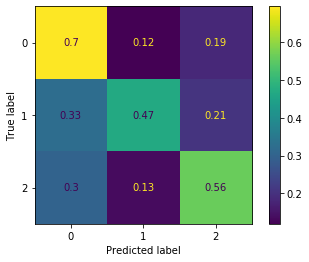

In [ ]:
CM1U_SMOTE_true=plot_confusion_matrix(modelK1U,X1_validation,Y1_validation,normalize='true')

We get bad result, so we continued with the SMOTE method.

We trained a Second Model without Weather features

In [ ]:
data2=ML_data.copy()

In [ ]:
data2.drop(columns=['bikes_available','docks_available','Wind_Direction','Humidity','Pressure','Temperature','Wind_Speed','Rain',\
                    'Sunny','Cloudy','Foggy','Light Rain','Moderate Rain','Heavy Rain','Proximity to Rain','East','North','South','West'],inplace=True)

In [ ]:
X2_rest,X2_test,Y2_rest,Y2_test=train_test_split(data2.drop(columns=['Category']),data2['Category'],train_size=0.8,shuffle=True)
X2_train,X2_validation,Y2_train,Y2_validation=train_test_split(X2_rest,Y2_rest,train_size=0.8,shuffle=True)

In [ ]:
X2_train.columns

Index(['station_id', 'Holiday', 'Weekend', 'Hour', 'Month', 'Mountain View',
       'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose'],
      dtype='object')

In [ ]:
model2=SMOTE(sampling_strategy={0:200000,1:400000,2:240000},k_neighbors=3)

In [ ]:
Xresamp2_train,Yresamp2_train=model2.fit_sample(X2_train,Y2_train)

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (400000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 392183)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=Futu

In [ ]:
modelK2=KNeighborsClassifier()
modelK2.fit(Xresamp2_train,Yresamp2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
Y2_validation_pred=modelK2.predict(X2_validation)
np.average(Y2_validation_pred==Y2_validation)

0.7898494352591309

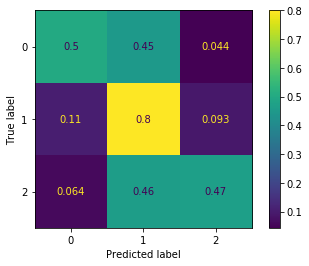

In [ ]:
CM2_SMOTE_true=plot_confusion_matrix(modelK2,X2_validation,Y2_validation,normalize='true')

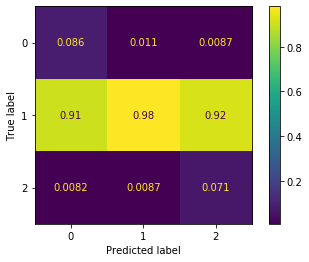

In [ ]:
CM2_SMOTE_pred=plot_confusion_matrix(modelK2,X2_validation,Y2_validation,normalize='pred')

We get a better accuracy on the True Labels, but we degrade the accuracy on the Predicted Labels. We have also a lower accuracy on the majority set.

We implemented a Gradient Boosting Classifier after the resampling, instead of a KNN, and on the same data set, to compare performances.

In [ ]:
modelGBC2=GradientBoostingClassifier(n_estimators=50,max_depth=3,verbose=2,learning_rate=0.25)

In [ ]:
modelGBC2.fit(Xresamp2_train,Yresamp2_train)

      Iter       Train Loss   Remaining Time 
         1      830840.7449            3.63m
         2      799821.6842            3.12m
         3      778690.9002            2.93m
         4      761258.1628            2.79m
         5      750172.1266            2.71m
         6      743305.7080            2.64m
         7      732911.2799            2.58m
         8      725552.7160            2.53m
         9      719000.6227            2.48m
        10      714971.0658            2.43m
        11      708972.0170            2.39m
        12      704968.4672            2.33m
        13      700689.4422            2.29m
        14      697725.1146            2.23m
        15      694306.7116            2.17m
        16      691184.3593            2.10m
        17      687244.3779            2.05m
        18      684554.5670            1.99m
        19      682412.2931            1.93m
        20      679665.8110            1.87m
        21      676065.3191            1.80m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [ ]:
Y2_validation_pred=modelGBC2.predict(X2_validation)
np.average(Y2_validation_pred==Y2_validation)

0.7310513928961803

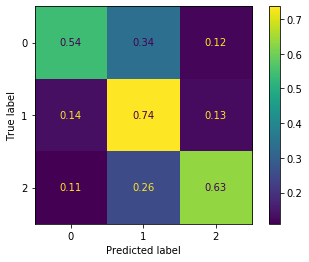

In [ ]:
CMGBC2_SMOTE_true=plot_confusion_matrix(modelGBC2,X2_validation,Y2_validation,normalize='true')

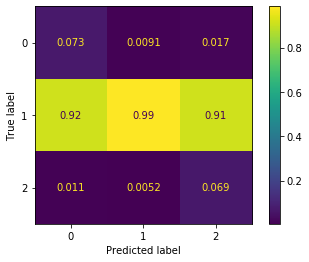

In [ ]:
CMGBC2_SMOTE_pred=plot_confusion_matrix(modelGBC2,X2_validation,Y2_validation,normalize='pred')

In this case, we get better accuracies on minorities, but we continue to degrade our performance on the normal stations.

In [ ]:
Y2_test_pred=modelGBC2.predict(X2_test)
np.average(Y2_test_pred==Y2_test)

0.7304532098094361

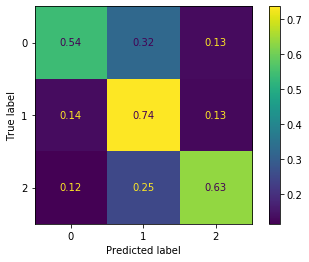

In [ ]:
CMGBC2_SMOTE_test_true=plot_confusion_matrix(modelGBC2,X2_test,Y2_test,normalize='true')

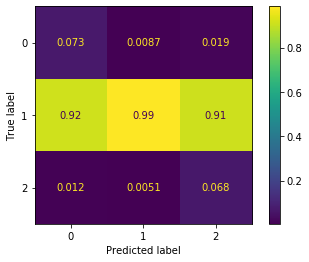

In [ ]:
CMGBC2_SMOTE_test_pred=plot_confusion_matrix(modelGBC2,X2_test,Y2_test,normalize='pred')

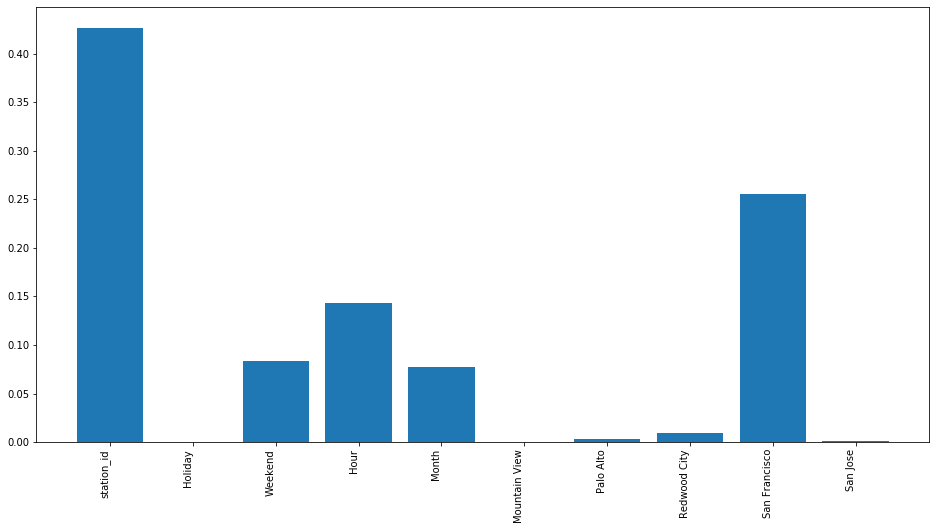

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X2_train.columns,modelGBC2.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

We selected Best Features from this model to train another one and limit the number of parameters.
But before, we implemented the same model than in KNN, which were our best model.

In [ ]:
data3=ML_data.copy()

In [ ]:
data3.drop(columns=['bikes_available','docks_available','Holiday','Weekend','Mountain View','Palo Alto','Redwood City','San Francisco','San Jose'],inplace=True)

In [ ]:
data3.columns

Index(['Category', 'station_id', 'Humidity', 'Pressure', 'Temperature',
       'Wind_Direction', 'Wind_Speed', 'Rain', 'Hour', 'Month', 'Cloudy',
       'Foggy', 'Heavy Rain', 'Light Rain', 'Moderate Rain',
       'Proximity to Rain', 'Sunny', 'East', 'North', 'South', 'West'],
      dtype='object')

In [ ]:
X3_rest,X3_test,Y3_rest,Y3_test=train_test_split(data3.drop(columns=['Category']),data3['Category'],train_size=0.8,shuffle=True)
X3_train,X3_validation,Y3_train,Y3_validation=train_test_split(X3_rest,Y3_rest,train_size=0.8,shuffle=True)

In [ ]:
# model3=SMOTE(sampling_strategy={0:200000,1:400000,2:220000},k_neighbors=3)
# model3=SMOTE(sampling_strategy={0:120000,1:400000,2:140000},k_neighbors=3)
model3=SMOTE(sampling_strategy='not majority',k_neighbors=3)

In [ ]:
Xresamp3_train,Yresamp3_train=model3.fit_sample(X3_train,Y3_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
modelK3=KNeighborsClassifier(3)
modelK3.fit(Xresamp3_train,Yresamp3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y3_validation_pred=modelK3.predict(X3_validation)
np.average(Y3_validation_pred==Y3_validation)

0.8920640860257407

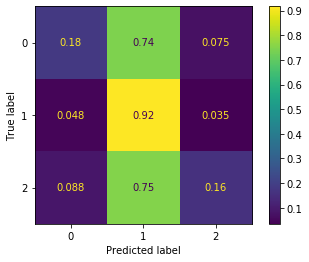

In [ ]:
CM3_SMOTE_true=plot_confusion_matrix(modelK3,X3_validation,Y3_validation,normalize='true')

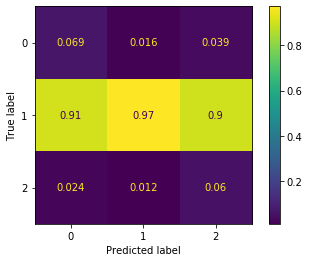

In [ ]:
CM3_SMOTE_pred=plot_confusion_matrix(modelK3,X3_validation,Y3_validation,normalize='pred')

We see that resampled KNN underperform compared to vanilla KNN.

In [ ]:
modelGBC3=GradientBoostingClassifier(n_estimators=50,max_depth=3,verbose=2,learning_rate=0.25)

In [ ]:
modelGBC3.fit(Xresamp3_train,Yresamp3_train)

      Iter       Train Loss   Remaining Time 
         1     1217741.5655           16.34m
         2     1171046.2943           15.99m
         3     1136080.3158           15.72m
         4     1106877.3036           15.40m
         5     1087481.1575           15.13m
         6     1061744.5798           14.77m
         7     1034951.5312           14.45m
         8     1019301.9147           14.08m
         9      999485.7461           13.69m
        10      990519.8391           13.32m
        11      983900.9628           12.95m
        12      972118.8016           12.58m
        13      956649.7757           12.21m
        14      950315.3974           11.91m
        15      941072.6254           11.62m
        16      932393.2324           11.28m
        17      921536.9985           10.95m
        18      916695.4157           10.61m
        19      910271.2160           10.33m
        20      904674.1038           10.03m
        21      899455.4746            9.70m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [ ]:
Y3_validation_pred=modelGBC3.predict(X3_validation)
np.average(Y3_validation_pred==Y3_validation)

0.809662140205414

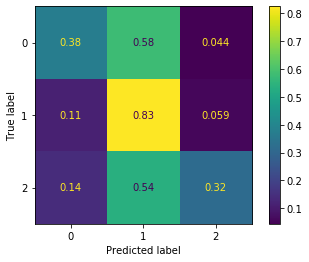

In [ ]:
CMGBC3_SMOTE_true=plot_confusion_matrix(modelGBC3,X3_validation,Y3_validation,normalize='true')

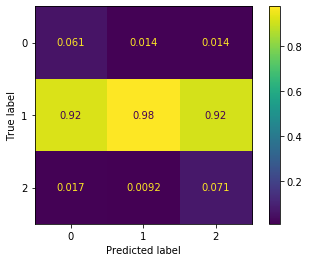

In [ ]:
CMGBC3_SMOTE_pred=plot_confusion_matrix(modelGBC3,X3_validation,Y3_validation,normalize='pred')

And this is the same for GBC.

In [ ]:
Y3_test_pred=modelGBC3.predict(X3_test)
np.average(Y3_test_pred==Y3_test)

0.8111691442346324

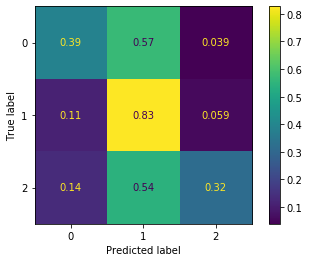

In [ ]:
CMGBC3_SMOTE_test_true=plot_confusion_matrix(modelGBC3,X3_test,Y3_test,normalize='true')

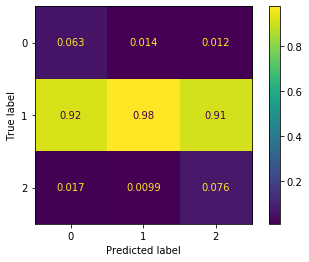

In [ ]:
CMGBC3_SMOTE_test_pred=plot_confusion_matrix(modelGBC3,X3_test,Y3_test,normalize='pred')

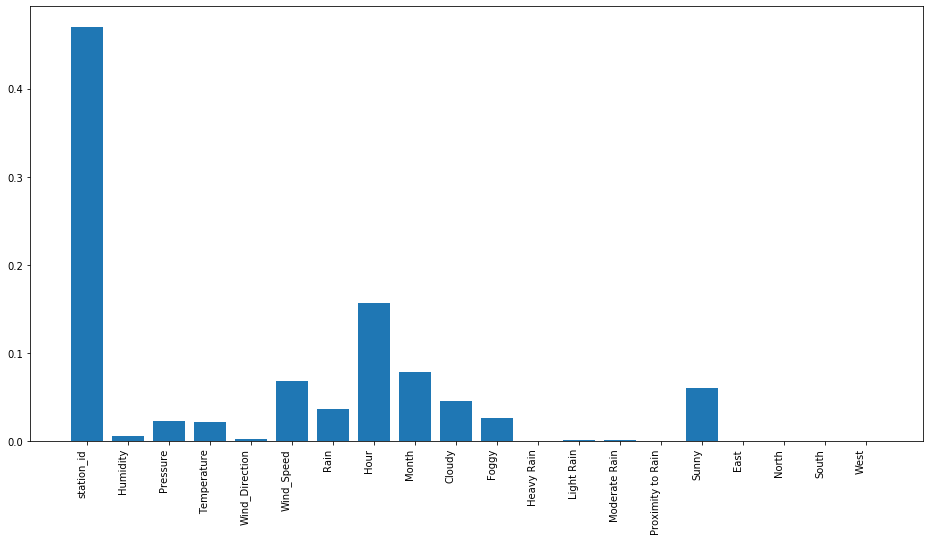

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X3_train.columns,modelGBC3.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

We selected only best Features to fit our model, and resample our data.

In [ ]:
data4=ML_data.copy()
data4.drop(columns=['bikes_available','docks_available','Holiday','Mountain View','Palo Alto','Redwood City','San Francisco','San Jose','Wind_Direction',\
                    'Humidity','Heavy Rain','Light Rain','Moderate Rain','Proximity to Rain','East','North','South','West'],inplace=True)

In [ ]:
X4_rest,X4_test,Y4_rest,Y4_test=train_test_split(data4.drop(columns=['Category']),data4['Category'],train_size=0.8,shuffle=True)
X4_train,X4_validation,Y4_train,Y4_validation=train_test_split(X4_rest,Y4_rest,train_size=0.8,shuffle=True)

In [ ]:
# model4=SMOTE(sampling_strategy={0:200000,1:400000,2:220000},k_neighbors=3)
# model4=SMOTE(sampling_strategy={0:120000,1:400000,2:140000},k_neighbors=3)
model4=SMOTE(sampling_strategy='not majority',k_neighbors=3)

In [ ]:
Xresamp4_train,Yresamp4_train=model4.fit_sample(X4_train,Y4_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
modelK4=KNeighborsClassifier(3)
modelK4.fit(Xresamp4_train,Yresamp4_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y4_validation_pred=modelK4.predict(X4_validation)
np.average(Y4_validation_pred==Y4_validation)

0.8922314895963604

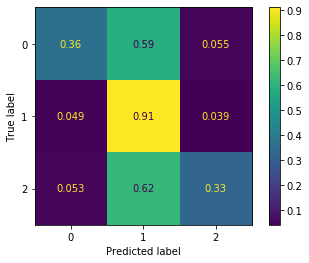

In [ ]:
CM4_SMOTE_true=plot_confusion_matrix(modelK4,X4_validation,Y4_validation,normalize='true')

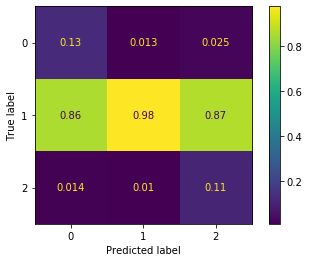

In [ ]:
CM4_SMOTE_pred=plot_confusion_matrix(modelK4,X4_validation,Y4_validation,normalize='pred')

We get our best result for the moment with resampled KNN, but this is still under vanilla KNN.

In [ ]:
modelGBC4=GradientBoostingClassifier(n_estimators=50,max_depth=3,verbose=2,learning_rate=0.25)

In [ ]:
modelGBC4.fit(Xresamp4_train,Yresamp4_train)

      Iter       Train Loss   Remaining Time 
         1     1215270.1651           11.50m
         2     1166353.5983           11.52m
         3     1128821.7128           11.39m
         4     1101053.3904           11.06m
         5     1081973.0114           10.74m
         6     1060075.1453           10.63m
         7     1042876.7935           10.48m
         8     1027984.2163           10.24m
         9     1016381.6183            9.94m
        10      996594.3768            9.70m
        11      985415.6723            9.44m
        12      975235.2000            9.16m
        13      964567.2115            8.95m
        14      949499.2728            8.74m
        15      942096.7578            8.54m
        16      932284.6220            8.31m
        17      925575.8889            8.07m
        18      919426.7810            7.80m
        19      908328.9205            7.55m
        20      900906.9957            7.32m
        21      894822.8568            7.06m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [ ]:
Y4_validation_pred=modelGBC4.predict(X4_validation)
np.average(Y4_validation_pred==Y4_validation)

0.8070624612263788

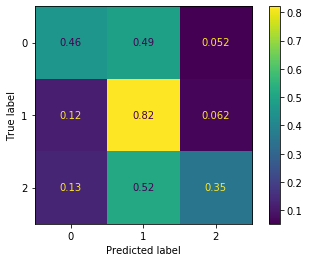

In [ ]:
CMGBC4_SMOTE_true=plot_confusion_matrix(modelGBC4,X4_validation,Y4_validation,normalize='true')

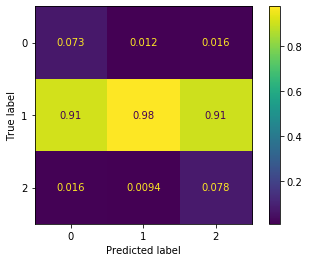

In [ ]:
CMGBC4_SMOTE_pred=plot_confusion_matrix(modelGBC4,X4_validation,Y4_validation,normalize='pred')

In [ ]:
Y4_test_pred=modelGBC4.predict(X4_test)
np.average(Y4_test_pred==Y4_test)

0.8099638408999599

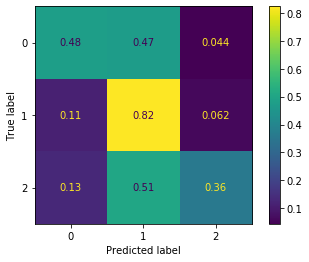

In [ ]:
CMGBC4_SMOTE_test_true=plot_confusion_matrix(modelGBC4,X4_test,Y4_test,normalize='true')

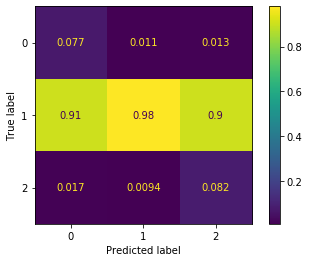

In [ ]:
CMGBC4_SMOTE_test_pred=plot_confusion_matrix(modelGBC4,X4_test,Y4_test,normalize='pred')

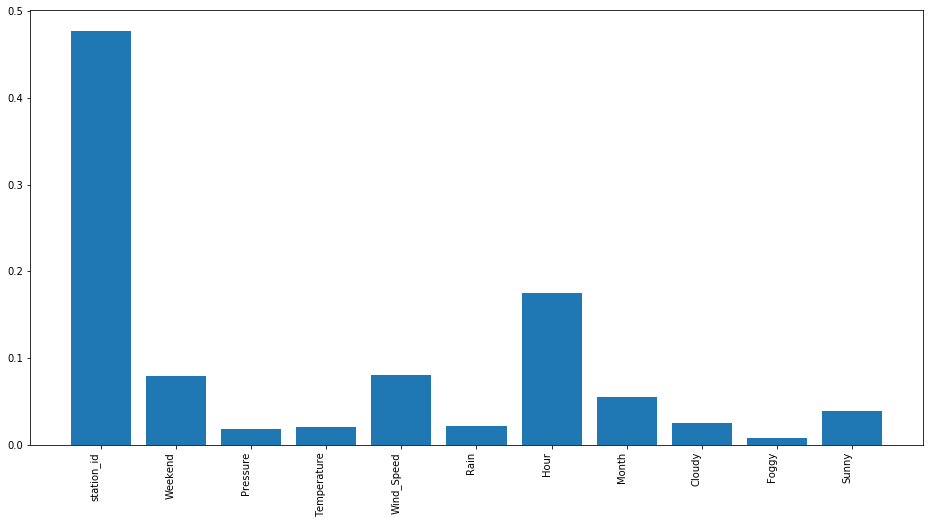

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X4_train.columns,modelGBC4.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Our performance on GBC is comparable to the one we get in the first Notebook.

In [ ]:
data5=ML_data.copy()
data5.drop(columns=['bikes_available','docks_available','Holiday','Mountain View','Palo Alto','Redwood City','San Jose','Wind_Direction',\
                    'Humidity','Heavy Rain','Light Rain','Moderate Rain','Proximity to Rain','East','North','South','West',\
                    'Pressure','Temperature','Rain','Cloudy','Foggy','Sunny','Wind_Speed'],inplace=True)

In [ ]:
X5_rest,X5_test,Y5_rest,Y5_test=train_test_split(data5.drop(columns=['Category']),data5['Category'],train_size=0.8,shuffle=True)
X5_train,X5_validation,Y5_train,Y5_validation=train_test_split(X5_rest,Y5_rest,train_size=0.8,shuffle=True)

In [ ]:
model5=SMOTE(sampling_strategy='not majority',k_neighbors=3)

In [ ]:
Xresamp5_train,Yresamp5_train=model5.fit_sample(X5_train,Y5_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
modelK5=KNeighborsClassifier(3)
modelK5.fit(Xresamp5_train,Yresamp5_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
Y5_validation_pred=modelK5.predict(X5_validation)
np.average(Y5_validation_pred==Y5_validation)

0.7586138984352689

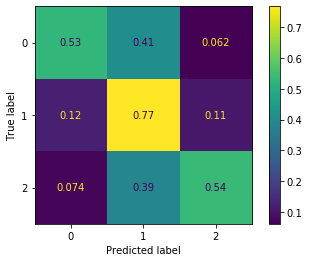

In [ ]:
CM5_SMOTE_true=plot_confusion_matrix(modelK5,X5_validation,Y5_validation,normalize='true')

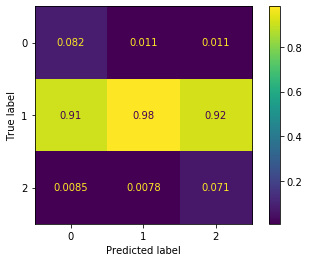

In [ ]:
CM5_SMOTE_pred=plot_confusion_matrix(modelK5,X5_validation,Y5_validation,normalize='pred')

We see amore accurate results on the minority classes. let's test it with a GBC model.

We optimized the max_depth and the learning_rate by hand validation to converge to this optimal model.

In [ ]:
modelGBC5=GradientBoostingClassifier(n_estimators=50,max_depth=6,verbose=2,learning_rate=0.9)

In [ ]:
modelGBC5.fit(Xresamp5_train,Yresamp5_train)

      Iter       Train Loss   Remaining Time 
         1      988299.5071            6.58m
         2      920001.0332            6.46m
         3      864461.5695            6.73m
         4      813986.4396            6.62m
         5      767867.5768            6.55m
         6      744024.3129            6.34m
         7      731174.5066            6.15m
         8      712424.9598            5.94m
         9      693476.2370            5.75m
        10      678680.8511            5.59m
        11      669451.1197            5.43m
        12      658068.7480            5.27m
        13      647081.4595            5.11m
        14      640173.4455            4.97m
        15      633280.5812            4.83m
        16      626192.7766            4.68m
        17      619431.0889            4.53m
        18      614804.7698            4.42m
        19      609688.5178            4.29m
        20      602954.1998            4.15m
        21      597953.8568            4.00m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.9, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [ ]:
Y5_validation_pred=modelGBC5.predict(X5_validation)
np.average(Y5_validation_pred==Y5_validation)

0.6925781134602318

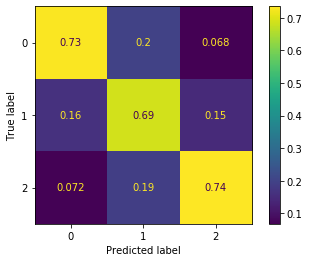

In [ ]:
CMGBC5_SMOTE_true=plot_confusion_matrix(modelGBC5,X5_validation,Y5_validation,normalize='true')

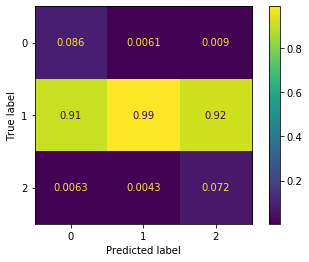

In [ ]:
CMGBC5_SMOTE_pred=plot_confusion_matrix(modelGBC5,X5_validation,Y5_validation,normalize='pred')

We get good predictions on both minorities, on both validation and testing sets.

But, we have deteriorated the accuracy on the normal situation.

In [ ]:
Y5_test_pred=modelGBC5.predict(X5_test)
np.average(Y5_test_pred==Y5_test)

0.6925688716627671

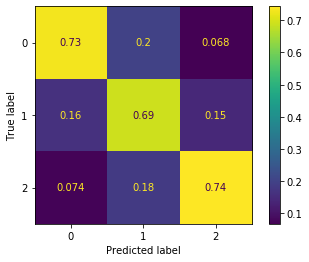

In [ ]:
CMGBC5_SMOTE_test_true=plot_confusion_matrix(modelGBC5,X5_test,Y5_test,normalize='true')

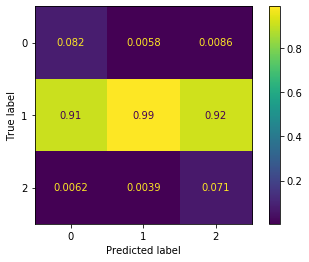

In [ ]:
CMGBC5_SMOTE_test_pred=plot_confusion_matrix(modelGBC5,X5_test,Y5_test,normalize='pred')

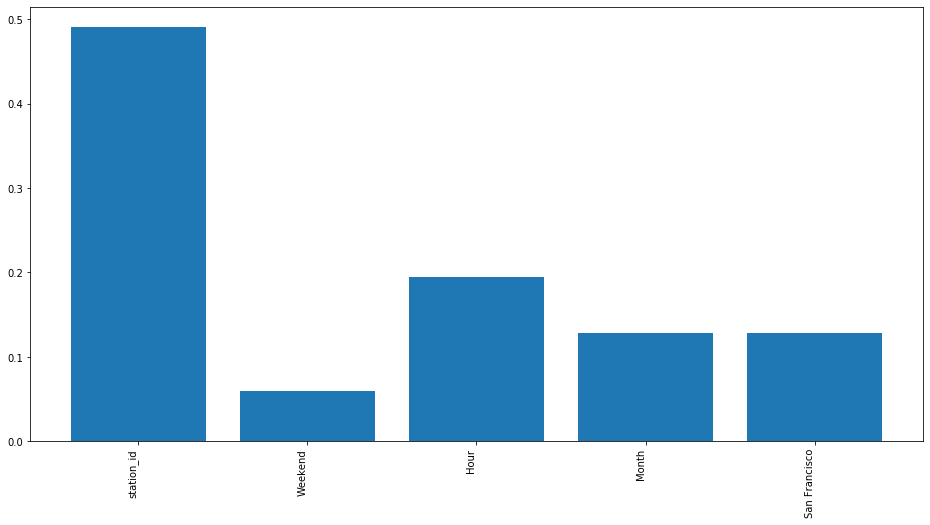

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X5_train.columns,modelGBC5.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

An interesting analysis, if we increase the maximum depth by 1, we will see the accuracy of the majority increasing again, letting the minority accuracies decreasing. Therefore, we find a (at least local) optimal model for handling minorities.

In [ ]:
modelGBC5_bis=GradientBoostingClassifier(n_estimators=50,max_depth=7,verbose=2,learning_rate=0.8)

In [ ]:
modelGBC5_bis.fit(Xresamp5_train,Yresamp5_train)

      Iter       Train Loss   Remaining Time 
         1      953311.8469            7.09m
         2      876830.1507            6.95m
         3      795983.7719            7.05m
         4      739108.3187            6.88m
         5      709908.8505            6.75m
         6      685443.7433            6.64m
         7      668520.1934            6.53m
         8      652717.9730            6.43m
         9      637741.3063            6.30m
        10      625292.6879            6.16m
        11      611705.2059            6.01m
        12      602025.3989            5.85m
        13      591315.8699            5.73m
        14      585560.8856            5.67m
        15      577733.4856            5.57m
        16      570551.6898            5.46m
        17      562660.4409            5.35m
        18      557767.8367            5.21m
        19      551150.2219            5.06m
        20      547938.1014            4.90m
        21      541801.7707            4.76m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [ ]:
Y5_bis_validation_pred=modelGBC5_bis.predict(X5_validation)
np.average(Y5_bis_validation_pred==Y5_validation)

0.7128339455052142

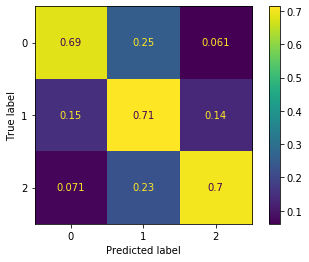

In [ ]:
CMGBC5_bis_SMOTE_true=plot_confusion_matrix(modelGBC5_bis,X5_validation,Y5_validation,normalize='true')

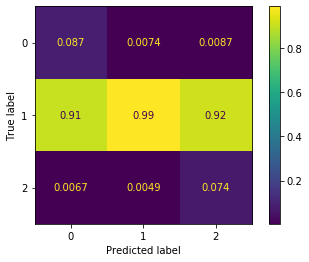

In [ ]:
CMGBC5_bis_SMOTE_pred=plot_confusion_matrix(modelGBC5_bis,X5_validation,Y5_validation,normalize='pred')

In [ ]:
Y5_bis_test_pred=modelGBC5_bis.predict(X5_test)
np.average(Y5_bis_test_pred==Y5_test)

0.7138861973073681

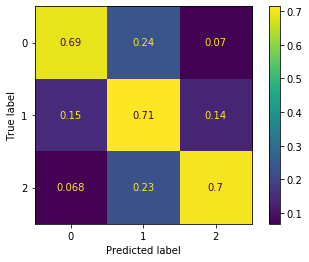

In [ ]:
CMGBC5_bis_SMOTE_test_true=plot_confusion_matrix(modelGBC5_bis,X5_test,Y5_test,normalize='true')

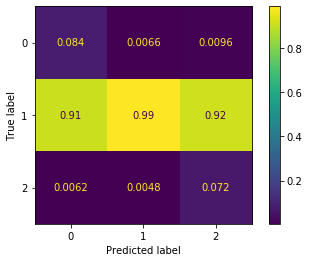

In [ ]:
CMGBC5_bis_SMOTE_test_pred=plot_confusion_matrix(modelGBC5_bis,X5_test,Y5_test,normalize='pred')

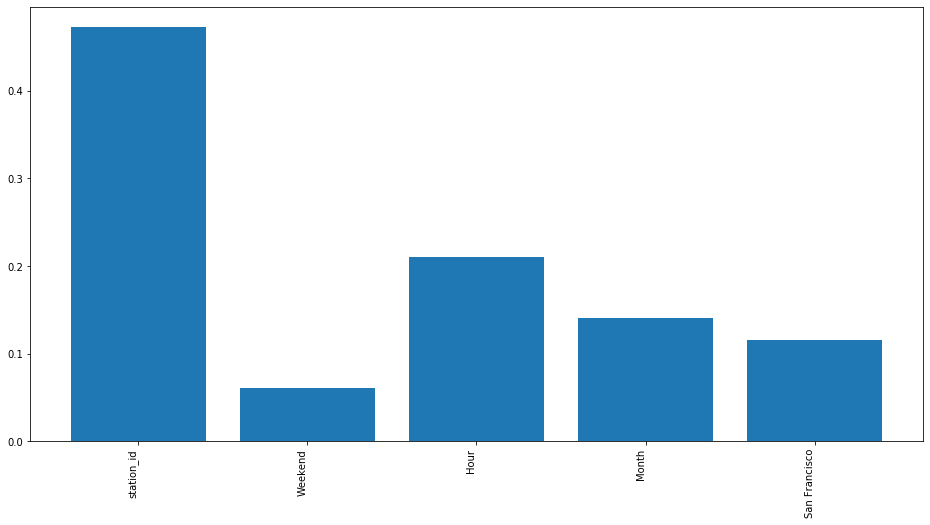

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(X5_train.columns,modelGBC5_bis.feature_importances_)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()